<a href="https://colab.research.google.com/github/proxxima/EmoNet/blob/main/Navarasa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
root_dir = '/content/drive/MyDrive/RAF_Dataset/Single Emotions/Train_set'

In [ ]:
import os
os.listdir(root_dir)

['Train', 'train_label.csv']

In [ ]:
import torch, torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([ transforms.ToPILImage(), 
                                transforms.Resize((64 ,64)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.4681, 0.4030, 0.5275] , std =[1.5016, 1.5685, 1.5956])])

In [ ]:
import pandas as pd

po = pd.read_csv('/content/drive/MyDrive/RAF_Dataset/Single Emotions/Train_set/train_label.csv')
po['Label'].value_counts(ascending = False)

4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: Label, dtype: int64

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

class RAF_Dataset(Dataset):

  def __init__(self,csv_file,root_dir,transform=None):

    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,idx):
    img_path = os.path.join(self.root_dir,self.annotations.iloc[idx,0])
    image = read_image(img_path)
    label = torch.tensor(int(self.annotations.iloc[idx,1]))

    if self.transform:
      image = self.transform(image)

      return(image,label)

In [ ]:
train_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/RAF_Dataset/Single Emotions/Train_set/train_label.csv' , 
                         root_dir = '/content/drive/MyDrive/RAF_Dataset/Single Emotions/Train_set/Train' ,
                         transform = transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


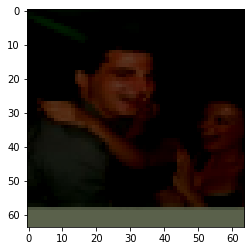

In [ ]:
import matplotlib.pyplot as plt
sample = train_set[580][0].numpy().transpose(1,2,0)
plt.imshow(sample)
#print(train_set [0][3])

In [ ]:
train_loaders = torch.utils.data.DataLoader(train_set, batch_size=32,shuffle=True ) 

In [ ]:
def mean_std(loader):
  chn_sum , chn_squ_sum , num_batch = 0,0,0

  for data,_ in loader:
    chn_sum  += torch.mean(data , dim = [0,2,3])
    chn_squ_sum += torch.mean(data**2 , dim = [0,2,3])
    num_batch += 1
  
  mean = chn_sum / num_batch
  std = (chn_squ_sum/num_batch - mean**2) ** 0.5
  return mean , std

In [ ]:

mean, std = mean_std(train_loaders)
#mean.type()
print(mean)
print(std)

tensor([0.4681, 0.4030, 0.5275])
tensor([1.5016, 1.5685, 1.5956])


In [ ]:
images,labels = next(iter(train_loaders))

#labels = ['Surprise' , 'Fear' , 'Disgust' ,'Happiness' ,'Sadness' ,'Anger' ,'Neutral']
#l_dict = {v:k for k, v in enumerate(labels)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


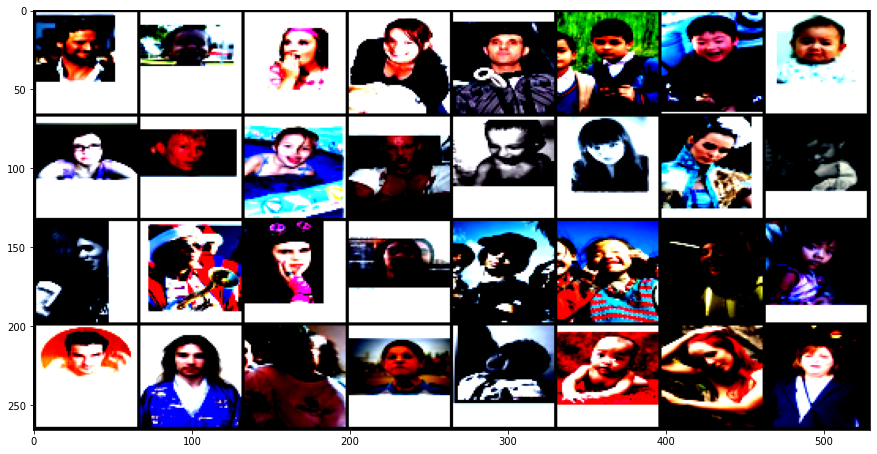

In [ ]:
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images , nrows = 1)
sample = grid.numpy().transpose(1,2,0)
plt.figure(figsize=(15,15))
plt.imshow(sample)

In [ ]:
device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
model = torchvision.models.resnet101(pretrained=False)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features,500),nn.ReLU(),nn.Dropout(),nn.Linear(500,7))
#print(model)

In [ ]:
import torch.nn as nn
crit = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters() , lr = 1e-4)
scalar = torch.cuda.amp.GradScaler()

In [ ]:
num_epochs =30
total_step = len(train_loaders)


for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    for i, (images,labels) in enumerate(train_loaders):
        images = images.to(device)
        labels = labels.to(device)
        model = model.to(device)
        optim.zero_grad()
        with torch.cuda.amp.autocast():

          outputs = model(images)
          loss = crit(outputs, labels)

        loss.backward()
        optim.step()
      
        
        if i % 25 == 24:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/30], Step [25/384], Loss: 1.7564
Epoch [1/30], Step [50/384], Loss: 1.7449
Epoch [1/30], Step [75/384], Loss: 1.6089
Epoch [1/30], Step [100/384], Loss: 1.6840
Epoch [1/30], Step [125/384], Loss: 1.4271
Epoch [1/30], Step [150/384], Loss: 1.4615
Epoch [1/30], Step [175/384], Loss: 1.5119
Epoch [1/30], Step [200/384], Loss: 1.6200
Epoch [1/30], Step [225/384], Loss: 1.5229
Epoch [1/30], Step [250/384], Loss: 1.5664
Epoch [1/30], Step [275/384], Loss: 1.7578
Epoch [1/30], Step [300/384], Loss: 1.7116
Epoch [1/30], Step [325/384], Loss: 1.6236
Epoch [1/30], Step [350/384], Loss: 1.8722
Epoch [1/30], Step [375/384], Loss: 1.8260
Epoch [2/30], Step [25/384], Loss: 1.5672
Epoch [2/30], Step [50/384], Loss: 1.9276
Epoch [2/30], Step [75/384], Loss: 1.5311
Epoch [2/30], Step [100/384], Loss: 1.3594
Epoch [2/30], Step [125/384], Loss: 1.8789
Epoch [2/30], Step [150/384], Loss: 1.7057
Epoch [2/30], Step [175/384], Loss: 1.5761
Epoch [2/30], Step [200/384], Loss: 1.7003
Epoch [2/30], Ste

In [ ]:
test_set = RAF_Dataset ( csv_file = '/content/drive/MyDrive/RAF_Dataset/Single Emotions/Test_set/test_label.csv' , 
                         root_dir = '/content/drive/MyDrive/RAF_Dataset/Single Emotions/Test_set/Test' ,
                         transform = transform)

test_loaders = torch.utils.data.DataLoader(test_set, batch_size=64,shuffle=False )

In [ ]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images1, labels1 in test_loaders:
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        model = model.to(device)
        outputs1 = model(images1)
        _, predicted = torch.max(outputs1.data, 1)
        total += labels1.size(0)
        correct += (predicted == labels1).sum().item()
    
    print('accuracy of model is : {} %' .format(100*correct/total))



accuracy of model is : 36.76662320730117 %


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

#model = torchvision.models.resnet18(pretrained = "False")
#model.load_state_dict(torch.load('model_weights.pth'))
#model.to(device)